In [1]:
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install statsmodels
!pip install xgboost

## Create a Gradient Boost Model model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

#from sktime.forecasting import arima
%load_ext autoreload 
%autoreload 2

# import helper python files
import functions as fun
import grad_boost_help as gbf

In [2]:
# load the dataset
dataset = pd.read_csv('training_data.csv')
# dropp unncecassary columns
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

,epoch_utc,emission_factor,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,298.240217,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,266.522473,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,262.594215,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,260.190772,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,250.496683,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


In [3]:
# Split dataset int targe = co2 emisssions and features

# get co2 emissions
co2 = dataset['emission_factor']

# get features
cols_features = [c for c in dataset.columns if c != 'emission_factor']
cols = {c: i for i, c in enumerate(dataset.columns)}
indices = {ind: i for i, ind in enumerate(dataset.index)}
features = dataset.loc[:, [j for j in cols if j != 'emission_factor' and j in cols_features]]

In [4]:
# check co2 data
co2.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64

In [5]:
# check features
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


## Feature Enginnering

### Create lagged features

In [6]:
# create 26 laggs of the co2 emission factor

co2_lag = fun.make_lags(co2, lags = 125)
co2_lag = co2_lag.fillna(0.0)
co2_lag.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,...,y_lag_116,y_lag_117,y_lag_118,y_lag_119,y_lag_120,y_lag_121,y_lag_122,y_lag_123,y_lag_124,y_lag_125
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,298.240217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,266.522473,298.240217,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,262.594215,266.522473,298.240217,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260.190772,262.594215,266.522473,298.240217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# add lag 24 and 26 to the features

features[['co2_24_lag', 'co2_26_lag']] = co2_lag[['y_lag_24','y_lag_26']].set_index(features.index)
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0,0.0,0.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0,0.0,0.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0,0.0,0.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0,0.0,0.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0,0.0,0.0


In [8]:
# add lag 24 and 26 to the features

#features[['co2_24_lag','co2_46_lag','co2_72_lag','co2_96_lag','co2_120_lag']] = co2_lag[['y_lag_24','y_lag_46','y_lag_72','y_lag_96','y_lag_120' ]].set_index(features.index)
#features.head()

### Create temproal features

In [9]:
# get datetime type timestemps from fetures
date =pd.to_datetime(features.datetime_de)

In [10]:
# one hot encoding of timestemps of features

features['hour_of_day'] = date.dt.hour # get hour of the given day
features['day_of_week'] = date.dt.weekday # get day of current weak
features['hour_of_year'] = ((date.dt.dayofyear-1) * 24) + date.dt.hour # get hour of current year
features = features.drop(columns=['datetime_de', 'epoch_utc']) # drop the timestemps
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag,hour_of_day,day_of_week,hour_of_year
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1354.0,224.0,0.0,0.0,800.0,0.0,0.0,23,0,8759
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,1158.0,0.0,0.0,1.0,801.0,0.0,0.0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,1176.0,0.0,0.0,0.0,800.0,0.0,0.0,1,1,1
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,1428.0,0.0,0.0,0.0,800.0,0.0,0.0,2,1,2
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,1492.0,0.0,0.0,0.0,800.0,0.0,0.0,3,1,3


In [11]:
features['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
features = pd.get_dummies(features, columns=['day_of_week'])
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,co2_26_lag,hour_of_day,hour_of_year,day_of_week_fri,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,0.0,23,8759,0,1,0,0,0,0,0
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0.0,0,0,0,0,0,0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0.0,1,1,0,0,0,0,0,1,0
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0.0,2,2,0,0,0,0,0,1,0
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0.0,3,3,0,0,0,0,0,1,0


In [12]:
# transform hourly features into ciclical data

features_temp = ['hour_of_day', 'hour_of_year']
corr_numbers = [24, 8760]# hours in a day and hours in a year
for f, n in zip(features_temp, corr_numbers):
    features[f + '_sin'] = np.sin(features[f]*(2.*np.pi/n))
    features[f + '_cos'] = np.cos(features[f]*(2.*np.pi/n))
features.drop(columns=features_temp, inplace=True)
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998


In [13]:
#features = features.drop(columns= ['day_of_week_mon','day_of_week_tue', 'day_of_week_wed', 'day_of_week_thu', 'day_of_week_fri'])
#features.head()

## Creation of Gboost regressor 

### Train Test Split

In [14]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)]
co2_train_val = co2[0:int(n*val_ratio)]
co2_val = co2[int(n*train_ratio):int(n*val_ratio)]
co2_test = co2[int(n*val_ratio):]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)]
features_train_val = features[0:int(n*val_ratio)]
features_val = features[int(n*train_ratio):int(n*val_ratio)]
features_test = features[int(n*val_ratio):]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [15]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


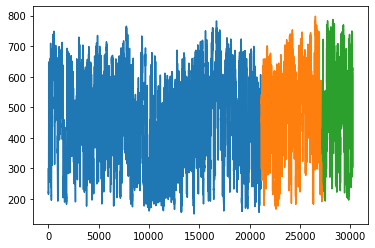

In [16]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

### Create walk forward split

In [17]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)

This is the length of the validation data set: 6048
This is the number of validation splits: 8
This is the length of one validation split: 756


In [18]:
from sklearn.model_selection import TimeSeriesSplit
# get object that contains split indexes accorcing to the test lenght and the forecast period

#define forecast period
forecast_period = 24
tscv_val = TimeSeriesSplit(gap = 0, test_size= val_len, n_splits = val_split)
tscv_test = TimeSeriesSplit(gap = 0, test_size= forecast_period, n_splits = int(len(co2_test)/forecast_period))

In [19]:
for train_index, test_index in tscv_val.split(co2_train_val):
    print("TRAIN:", train_index, "VALIDATE:", test_index)
    X_train, X_test = features.values[train_index], features.values[test_index]
    y_train, y_test = co2.values[train_index], co2.values[test_index]

TRAIN: [    0     1     2 ... 21164 21165 21166] VALIDATE: [21167 21168 21169 21170 21171 21172 21173 21174 21175 21176 21177 21178
 21179 21180 21181 21182 21183 21184 21185 21186 21187 21188 21189 21190
 21191 21192 21193 21194 21195 21196 21197 21198 21199 21200 21201 21202
 21203 21204 21205 21206 21207 21208 21209 21210 21211 21212 21213 21214
 21215 21216 21217 21218 21219 21220 21221 21222 21223 21224 21225 21226
 21227 21228 21229 21230 21231 21232 21233 21234 21235 21236 21237 21238
 21239 21240 21241 21242 21243 21244 21245 21246 21247 21248 21249 21250
 21251 21252 21253 21254 21255 21256 21257 21258 21259 21260 21261 21262
 21263 21264 21265 21266 21267 21268 21269 21270 21271 21272 21273 21274
 21275 21276 21277 21278 21279 21280 21281 21282 21283 21284 21285 21286
 21287 21288 21289 21290 21291 21292 21293 21294 21295 21296 21297 21298
 21299 21300 21301 21302 21303 21304 21305 21306 21307 21308 21309 21310
 21311 21312 21313 21314 21315 21316 21317 21318 21319 21320 2132

In [20]:
co2_train_val.shape, co2_test.shape, co2.shape, co2_val.shape

((27215,), (3024,), (30239,), (6048,))

In [21]:
# check the number of splits for the forward validation
tscv_val.get_n_splits(), tscv_test.get_n_splits()

(8, 126)

In [22]:
# check if the tscv splits align with the test data set
assert(tscv_val.get_n_splits() == co2_val.shape[0] / val_len)
assert(tscv_test.get_n_splits() == co2_test.shape[0] / forecast_period)

### Walk forward Grid Search

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [189]:
# define the grid for the grid search 
grid = {'learning_rate': [0.3],
        'n_estimators': [50, 100,150,200,250,300,350],
        #'max_samples': [0.75,1.0,],
        'subsample': [1.0],
        #'mean_sample_split' :[2,4,8],
        'max_depth': [3]
}

In [190]:
from sklearn.model_selection import GridSearchCV

In [191]:
rf_cv = GridSearchCV(estimator=GradientBoostingRegressor(random_state = 42), param_grid=grid, cv= tscv_val, scoring= 'neg_root_mean_squared_error', refit= True)
rf_cv.fit(features_train_val, co2_train_val)

KeyboardInterrupt: 

In [ ]:
# check the best estimator of the grid search
rf_cv.best_estimator_

In [76]:
# check the best parameters for the grid search
rf_cv.best_params_

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 350, 'subsample': 1.0}

In [77]:
# ceck the best scor of the grid serach
rf_cv.best_score_

-38.23520274984331

In [72]:
# save grid search as csv
df = pd.DataFrame(rf_cv.cv_results_ )
df.to_csv('grid_search_gradient_boosting6.csv')

In [73]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
0,6.288826,0.524747,0.002477,0.000144,0.3,3,50,1.0,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",-38.212547,-52.901684,-33.676564,-45.404526,-36.284231,-31.834029,-44.408719,-48.798686,-41.440123,7.067489,7
1,12.183703,0.905817,0.002779,0.000029,0.3,3,100,1.0,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",-36.412817,-51.453750,-30.358060,-41.714868,-35.198227,-31.201845,-42.345085,-44.562073,-39.155841,6.717884,6
2,18.263568,1.367568,0.003116,0.000050,0.3,3,150,1.0,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",-36.272869,-51.374722,-29.391901,-40.588229,-36.503436,-29.884528,-40.383812,-44.430688,-38.603773,6.845482,5
3,24.367372,1.826243,0.003541,0.000330,0.3,3,200,1.0,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",-36.341003,-51.953654,-28.763420,-42.181495,-36.859040,-28.800629,-40.075611,-43.397176,-38.546503,7.221795,4
4,43.396945,9.043565,0.005946,0.000929,0.3,3,250,1.0,"{'learning_rate': 0.3, 'max_depth': 3, 'n_esti...",-35.775833,-52.151952,-28.598528,-41.597362,-36.924260,-28.499611,-39.258662,-43.711643,-38.314731,7.343216,2


In [74]:
import joblib

In [75]:
# save th grid search model
joblib.dump(rf_cv,'grid_search_gradinet_boosting06.pkl')

['grid_search_gradinet_boosting06.pkl']

#### Optional: load pre-existing grid search

In [ ]:
gb_cv  = joblib.load('grid_search_gradinet_boosting3.pkl')

In [28]:
gb_cv.best_score_

-38.273584040601776

In [30]:
gb_cv.best_params_

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 400, 'subsample': 1.0}

In [32]:
gb_cv.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=756),
             estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.3], 'max_depth': [3, 6, 9],
                         'n_estimators': [400], 'subsample': [0.5, 0.75, 1.0]},
             scoring='neg_root_mean_squared_error')>

### Walk forward manuel validating

In [23]:
alpha_low = 0.025
alpha_high = 0.975

In [24]:
common_params = dict(
    learning_rate=0.3,
    n_estimators= 350,
    #mean_sample_split = 8
    max_depth = 3,
    subsample = 1.0
)

In [25]:
all_models = {}
for alpha in [alpha_low, alpha_high]:
    all_models["q %1.3f" % alpha] = GradientBoostingRegressor(loss = "quantile", alpha=alpha,**common_params, random_state = 42)
all_models['mean'] = GradientBoostingRegressor(loss = "quantile",alpha=0.5,**common_params, random_state = 42)

In [26]:
print(all_models['q %1.3f' % alpha_low])
print(all_models['mean'])

GradientBoostingRegressor(alpha=0.025, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42)
GradientBoostingRegressor(alpha=0.5, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42)


In [27]:
features.columns

Index(['windon_forecast', 'windoff_forecast', 'solar_forecast',
       'prices_forecast', 'aggregated_generation_forecast', 'AT_import',
       'AT_export', 'CZ_import', 'CZ_export', 'DK_import', 'DK_export',
       'LU_import', 'LU_export', 'NL_import', 'NL_export', 'PL_import',
       'PL_export', 'CH_import', 'CH_export', 'co2_24_lag', 'co2_26_lag',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_sat',
       'day_of_week_sun', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'hour_of_day_sin', 'hour_of_day_cos',
       'hour_of_year_sin', 'hour_of_year_cos'],
      dtype='object')

In [28]:
pred_val,report_val,lower_val,upper_val = gbf.walk_forward_gb(tscv_val, all_models, co2_train_val, features_train_val, co2_val, alpha_low, alpha_high, n_features, 'Gradient Boosting', refit = True)
print(report_val)

MAE for Gradient Boosting: 31.32 g_CO2/kWh
MAPE for Gradient Boosting: 7.17 %
RMSE for Gradient Boosting: 40.15 g_CO2/kWh
Pinball for lower Quantile Gradient Boosting: 2.94 g_CO2/kWh
Pinball for higher Quantile Gradient Boosting: 3.05 g_CO2/kWh
Interval Score Gradient Boosting: 139.447 g_CO2/kWh
Real Values insisde PI Gradient Boosting: 85.81 %
R2 Gradient Boosting: 90.9 %
Adjusted R2 Gradient Boosting: 90.85 %


In [29]:
pred_val_df = pd.DataFrame(pred_val)
#pred_val_df.index = co2_val.index
pred_val_df.head()


,0
0,521.206862
1,490.004445
2,511.975617
3,509.918812
4,561.597524


In [30]:
lower_val_df = pd.DataFrame(lower_val)
#pred_val_df.index = co2_val.index
lower_val_df.head()


,0
0,480.377007
1,430.466257
2,420.407278
3,420.407278
4,447.130192


In [31]:
upper_val_df = pd.DataFrame(upper_val)
#pred_val_df.index = co2_val.index
upper_val_df.head()


,0
0,656.276437
1,655.999593
2,667.632183
3,677.706754
4,677.706754


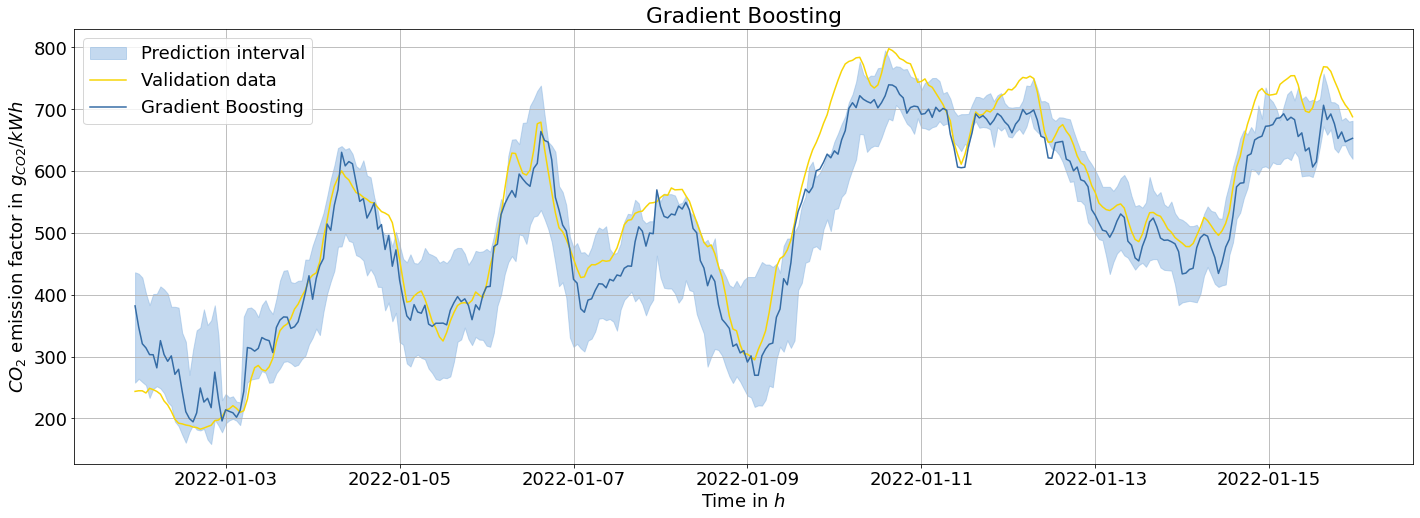

In [35]:
fun.plot_model_uncertainty2(co2_val, pred_val_df,lower_val_df ,upper_val_df, date_val, slice_start = '2022-01-01 23:00', slice_end =  '2022-01-15 23:00' , method = 'Gradient Boosting')

## Walk forward testing

In [36]:
common_params = dict(
    learning_rate=0.3,
    n_estimators= 350,
    #mean_sample_split = 8
    max_depth = 3,
    subsample = 1.0,
)

In [37]:
all_models = {}
for alpha in [alpha_low, alpha_high]:
    all_models["q %1.3f" % alpha] = GradientBoostingRegressor(loss = "quantile", alpha=alpha,**common_params, random_state = 42)
all_models['mean'] = GradientBoostingRegressor(loss = "quantile", alpha = 0.5, **common_params, random_state = 42)

In [38]:
print(all_models)

{'q 0.025': GradientBoostingRegressor(alpha=0.025, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42), 'q 0.975': GradientBoostingRegressor(alpha=0.975, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42), 'mean': GradientBoostingRegressor(alpha=0.5, learning_rate=0.3, loss='quantile',
                          n_estimators=350, random_state=42)}


In [39]:
# define the confidence interval for the prediction
alpha_low = 0.025
alpha_high = 0.975
ci_width = alpha_high - alpha_low
print('width of confidence interval is:', ci_width)

width of confidence interval is: 0.95


In [40]:
pred_tet,report_test,lower_test,upper_test = gbf.walk_forward_gb(tscv_test, all_models, co2, features, co2_test, alpha_low, alpha_high, n_features, 'Gradient Boosting', refit = True)
print(report_test)

MAE for Gradient Boosting: 26.8 g_CO2/kWh
MAPE for Gradient Boosting: 6.03 %
RMSE for Gradient Boosting: 33.56 g_CO2/kWh
Pinball for lower Quantile Gradient Boosting: 2.21 g_CO2/kWh
Pinball for higher Quantile Gradient Boosting: 2.78 g_CO2/kWh
Interval Score Gradient Boosting: 132.9177 g_CO2/kWh
Real Values insisde PI Gradient Boosting: 87.9 %
R2 Gradient Boosting: 94.92 %
Adjusted R2 Gradient Boosting: 94.86 %


In [41]:
pred_test_df = pd.DataFrame(pred_tet)
pred_test_df.to_csv('best_gb_mean_wf_test3.csv')
pred_test_df.head() 

,0
0,381.753425
1,360.139829
2,368.270257
3,349.386349
4,344.190538


In [42]:
upper_test_df = pd.DataFrame(upper_test)
upper_test_df.to_csv('best_gb_upper_wf_test3.csv')
upper_test_df


,0
0,468.684832
1,452.398956
2,435.750386
3,423.106379
4,396.546968
...,...
3019,559.322648
3020,629.531447
3021,655.770751
3022,665.926292


In [43]:
lower_test_df = pd.DataFrame(lower_test)
lower_test_df.to_csv('best_gb_lower_wf_test3.csv')
lower_test_df

,0
0,327.651523
1,285.775341
2,277.129834
3,272.219209
4,271.539349
...,...
3019,430.342024
3020,466.415347
3021,526.528194
3022,539.509233


In [44]:
date_val = date[int(n*train_ratio):int(n*val_ratio)]
date_test = date[int(n*val_ratio):n]

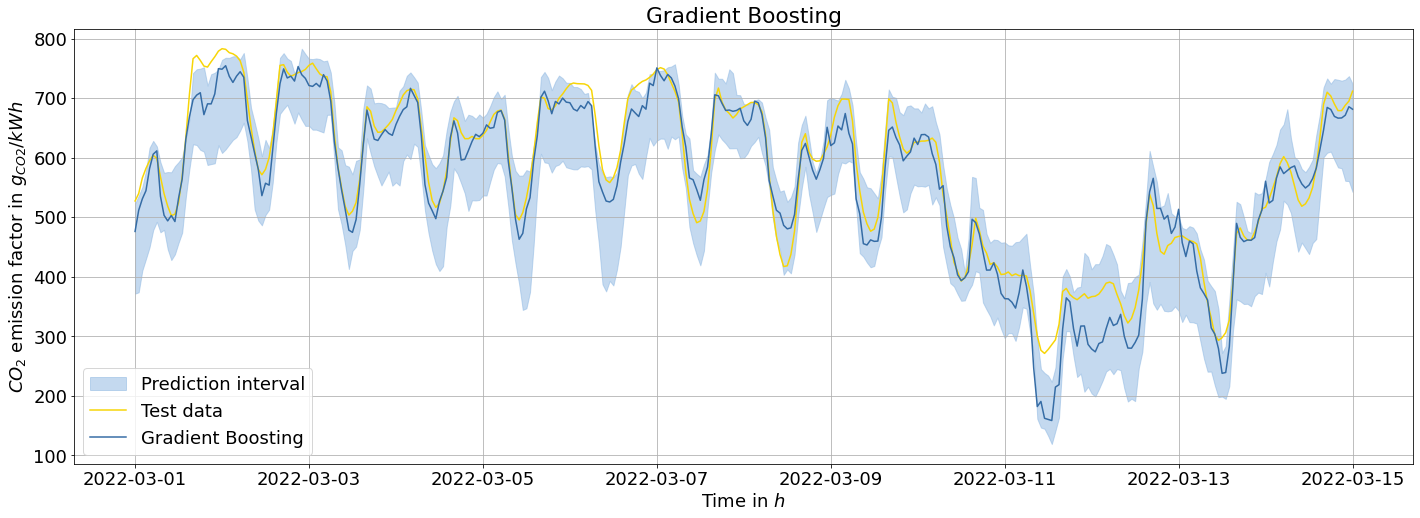

In [46]:
fun.plot_model_uncertainty(co2_test, pred_test_df, lower_test_df ,upper_test_df, date_test, slice_start = '2022-03-01 00:00', slice_end =  '2022-03-15 00:00', method = 'Gradient Boosting')

In [32]:
import joblib

In [33]:
joblib.dump(all_models, 'grad_boost_models.pkl')

['grad_boost_models.pkl']